## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf

from tensorflow import keras

from generate_TF import GenerateTF, get_freq
from pytorchClassifiers import Net, get_keras_nn

avg_pool1d = keras.layers.AveragePooling1D


2022-08-01 09:47:10.569543: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-01 09:47:10.611890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-08-01 09:47:10.611901: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load the data
df21 = pd.read_pickle('./data/tf-measurement-2021.pkl')
# print(df21.head())
df22 = pd.read_pickle('./data/tf-measurement-2022.pkl')
# print(df22.head())
df = pd.concat([df21, df22])
df.head()

,freq,amplitude,real,imag
3B2_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-21.777909296765575, -15.057012209125634, -14...","[0.08133579725841898, 0.051474840390077534, 0....","[0.005011469983590167, -0.16899911501622603, 0..."
4B1_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-16.549652269096566, -20.01969655997585, -20....","[-0.026679795952774418, -0.07647726969086971, ...","[-0.1463588317648657, -0.06407789716197017, 0...."
1B1_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-20.2673641620488, -19.779742221907256, -18.4...","[0.09695721712767796, 0.09919239881532062, 0.0...","[-0.0014954233612149335, -0.026098106680390566..."
5B2_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-13.816465626241573, -19.706971066659623, -25...","[0.15931370325321093, 0.06474392932533353, -0....","[-0.12707608641609552, -0.08066121124737649, -..."
3B1_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-14.487696517960305, -27.50301068354199, -27....","[0.1625850605118769, 0.01047347697587523, 0.03...","[-0.09564568737505466, -0.04083323830963009, 0..."


In [3]:
tempdf = pd.read_pickle('./data/tf-ampl-response-82000-noise0.1.pkl')

phi_encoder = preprocessing.LabelEncoder()
phi_encoder.fit(tempdf['phase'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
gain_encoder.fit(tempdf['gain'])
print(gain_encoder.classes_)


# target_orig is the vector with the originale phase, gain labels
target_orig = np.array((tempdf.phase, tempdf.gain), dtype=np.float32).T
target_scaler = preprocessing.StandardScaler().fit(target_orig)

del tempdf


[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.001      0.00107569 0.00115711 0.00124469 0.0013389  0.00144025
 0.00154926 0.00166652 0.00179266 0.00192835 0.00207431 0.00223132
 0.00240021 0.00258188 0.0027773  0.00298752 0.00321364 0.00345689
 0.00371854 0.004     ]


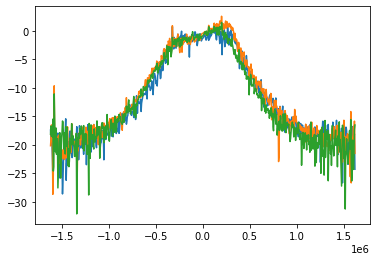

In [4]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['amplitude']
    x = row['freq']
    plt.plot(x, y)
plt.show()

In [5]:
# from scipy.signal import savgol_filter

# our dataset is 3D
values = np.zeros((len(df), len(df.iloc[0].real), 3), dtype=np.float32)
print(values.shape)
index = 0
for _, row in df.iterrows():
    # print(row)
    values[index, :, 0] = row.real
    values[index, :, 1] = row.imag
    values[index, :, 2] = row.amplitude
    index += 1
data = values

# data = torch.tensor(values, dtype=torch.float32)
# # data_scaler = preprocessing.StandardScaler().fit(values)
# savgol_data = np.zeros(values.shape)
# for row in range(len(savgol_data)):
#     savgol_data[row] = savgol_filter(values[row], 17, 1)
# savgol_data = torch.tensor(savgol_data, dtype=torch.float32)


(468, 662, 3)


In [6]:
# Initialize model, loss function and optimizer
# This is for the first parameter: phi
n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = 41
phase_torch_classif = Net(n_inputs, n_outputs, name='phase_classifier_noise0.1', activation_func=F.gelu,
             hidden_layers=(500, 200), avg_pool=(6, 6), trim_edges=135, verbose=1,
             with_batch_norm=True, save_best=True)
print(phase_torch_classif)

# specify loss function (regression)
criterion = nn.NLLLoss()

# specify optimizer
opt_phase_torch = torch.optim.Adam(phase_torch_classif.parameters(), lr=0.005)


Net(
  (center): ConstantPad1d(padding=(-135, -135), value=0)
  (avg_pool): AvgPool1d(kernel_size=(6,), stride=(6,), padding=(0,))
  (fc0): Linear(in_features=65, out_features=500, bias=True)
  (batch_norm0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout0): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=500, out_features=200, bias=True)
  (batch_norm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (out_layer): Linear(in_features=200, out_features=41, bias=True)
)


In [7]:
# Initialize model, loss function and optimizer
# This is for the second parameter: g_oo

n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = 20

gain_torch_classif = Net(n_inputs, n_outputs, name='gain_classifier_noise0.1', activation_func=F.gelu,
             hidden_layers= (420, 350), avg_pool=(4,4), trim_edges=120, save_best=True)

print(gain_torch_classif)

# specify loss function (regression)
criterion = nn.NLLLoss()

# specify optimizer
opt_gain_torch = torch.optim.Adam(gain_torch_classif.parameters(), lr=0.005)


Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (avg_pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc0): Linear(in_features=105, out_features=420, bias=True)
  (dropout0): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=420, out_features=350, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (out_layer): Linear(in_features=350, out_features=20, bias=True)
)


In [8]:
# load model with the highest accuracy

phase_torch_classif.load(optimizer=opt_phase_torch, filename='models/phase_classifier_noise0.1-acc73.pt')
gain_torch_classif.load(optimizer=opt_gain_torch, filename='models/gain_classifier_noise0.1-acc99.pt')

# keras models
phase_keras_reg = keras.models.load_model('models/keras/regression/phase_best')
gain_keras_reg = keras.models.load_model('models/keras/regression/gain_best')


2022-08-01 09:47:42.127541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-08-01 09:47:42.127562: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-01 09:47:42.127584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-08-01 09:47:42.128194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def curve_fit_deluxe(func, freq, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        freq, sample = freq[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # prepare the shapes for avg_pooling
    freq = freq.reshape(1, -1, 1)
    sample = sample.reshape(1, -1, 1)
    # perform average pooling
    freq = avg_pool1d(pool_size=kernel_size, strides=stride)(freq).numpy().flatten()
    sample = avg_pool1d(pool_size=kernel_size, strides=stride)(sample).numpy().flatten()
    # pass to curve_fit
    return curve_fit(func, freq, sample, **kwargs)


This region is to use gradio and visualize predictions

In [ ]:

def classify(measurement_id, show_user, phase, gain, save_to_file=None):
    phase, gain = float(phase), float(gain)
    # print(df.loc[measurement_id])
    freq = df.loc[measurement_id].freq
    amplitude = df.loc[measurement_id].amplitude
    real = df.loc[measurement_id].real
    imag = df.loc[measurement_id].imag
    resp = np.array([real, imag]).T.reshape(1, -1, 2)

    # savgol_amplitude = savgol_filter(amplitude, 17, 1)
    # print(savgol_amplitude.shape)

    table = []

    gen_tf_noise = GenerateTF(
        fb_attn_index=3, with_noise=True, noise_amplitude=0.1)
    gen_tf_no_noise = GenerateTF(fb_attn_index=3, with_noise=False)

    # I get one input with given phase, gain from X_validate or y_validate
    amplitude_tensor = torch.tensor([amplitude], dtype=torch.float32)
    # savgol_amplitude_tensor = torch.tensor([savgol_amplitude], dtype=torch.float32)

    # I make predictions with pytorch
    with torch.no_grad():
        phase_torch_classif.eval()
        gain_torch_classif.eval()
        phase_torch_pred = phase_torch_classif(
            torch.atleast_2d(amplitude_tensor))
        gain_torch_pred = gain_torch_classif(
            torch.atleast_2d(amplitude_tensor))

    # probs = torch.exp(pred_phase).numpy().ravel()
    # Extract top category
    _, phase_torch_pred = torch.exp(phase_torch_pred).topk(1, dim=1)
    _, gain_torch_pred = torch.exp(gain_torch_pred).topk(1, dim=1)

    # Get original value
    phase_torch_pred = phi_encoder.inverse_transform(
        phase_torch_pred.ravel().numpy())[0]
    gain_torch_pred = gain_encoder.inverse_transform(
        gain_torch_pred.ravel().numpy())[0]
    # sav_pred_phase = phi_encoder.inverse_transform(sav_pred_phase.ravel().numpy())[0]
    # sav_pred_gain = gain_encoder.inverse_transform(sav_pred_gain.ravel().numpy())[0]

    # Make predictions with keras
    phase_keras_pred = phase_keras_reg(resp, training=False).numpy()
    gain_keras_pred = gain_keras_reg(resp, training=False).numpy()
    keras_pred_scaled = np.array(
        [phase_keras_pred, gain_keras_pred]).reshape(1, -1)

    # Descale them to get original values
    keras_pred_descaled = target_scaler.inverse_transform(keras_pred_scaled)
    phase_keras_pred, gain_keras_pred = float(
        keras_pred_descaled[0, 0]), float(keras_pred_descaled[0, 1])

    # Get optimizers results
    (opt_phase, opt_gain), _ = curve_fit_deluxe(gen_tf_no_noise, freq, amplitude, trim_edges=130,
                                                kernel_size=4, stride=1,
                                                bounds=([-20, 0.001], [20, 0.004]), method='trf')

    # I add them to the table
    table.append(['phase',
                 str(np.round(phase_torch_pred, 4)),
                 str(np.round(phase_keras_pred, 4)),
                 str(np.round(opt_phase, 4)),
                 str(np.round(phase, 4))
                 ])
    table.append(['gain',
                 str(np.round(gain_torch_pred, 4)),
                 str(np.round(gain_keras_pred, 4)),
                 str(np.round(opt_gain, 4)),
                 str(np.round(gain, 4)),
                 ])

    # I plot them
    fig = plt.figure()
    plt.plot(freq, amplitude, label=f'Measurement',
             ls='-', color='black', alpha=0.5)
    plt.plot(freq, gen_tf_no_noise(freq, phase_torch_pred, gain_torch_pred), label=f'PyTorch',
             ls='--', color='tab:orange', lw=2)
    plt.plot(freq, gen_tf_no_noise(freq, phase_keras_pred, gain_keras_pred),
             label=f'Keras', ls='--', color='tab:purple', lw=2)
    plt.plot(freq, gen_tf_no_noise(freq, opt_phase, opt_gain), label=f'Optimizer',
             ls=':', color='tab:red', lw=2)
    if show_user:
        plt.plot(freq, gen_tf_no_noise(freq, phase, gain), label=f'User',
                ls='-', color='black', alpha=0.75)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    if save_to_file and len(save_to_file):
        fig.savefig(f'{save_to_file}/{measurement_id}.png', dpi=300)

    return fig, table
    # , {str(c): probs[i] for i, c in enumerate(phi_encoder.classes_)}


fig, table = classify('3B2_21', True, -15, 0.002)
# print(probs)
print(table)


In [13]:
import gradio as gr

# print(gain_encoder.classes_.astype(str).tolist())
# build the gradio interface
dropdown = gr.Dropdown(choices=list(df.index.values), label='Measurement')
slider_phase = gr.Slider(label='User Phase', minimum=-20., maximum=20., step=.5)
slider_gain = gr.Slider(label='User Gain',
                            minimum=0.001, maximum=0.004, step=0.0001)

checkbox = gr.Checkbox('Plot user input')

interface = gr.Interface(fn=classify,
                         inputs=[
                             dropdown,
                             checkbox,
                             slider_phase,
                             slider_gain
                         ],
                         outputs=[
                             gr.Plot(label='Graphical Evaluation'),
                             # gr.Textbox(lines=5),
                             gr.DataFrame(label='Numerical Evaluation',
                                          headers=['Param', 'PyTorch',
                                                   'Keras', 'Optimizer', 'User'],
                                          datatype=['str', 'number', 'number', 'number', 'number'],
                                          row_count=2, col_count=(5, 'fixed')),
                            #  gr.Label(label='Phase Probs', num_top_classes=10)
                         ],
                         interpretation="default",
                         live=True,
                         title='Measurement Data Evaluation'
                         )

interface.launch(debug=False)


Running on local URL:  http://127.0.0.1:7861/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f4eaac665b0>, 'http://127.0.0.1:7861/', None)

In [ ]:
# Save all classifications plots
for measurement_id in list(df.index.values):
    classify(measurement_id=measurement_id, show_user=False,
             phase=0.0, gain=0.0,
             save_to_file='plots/measurement_curves/evaluation')
